In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
overwrite_model=False
restore_model=True
train_model=False

# Setup

In [3]:
import os
os.environ['JAX_PLATFORMS']="cpu"
# os.environ['JAX_PLATFORMS']="cuda" 


from flax import nnx
import jax 
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

import time
import diffrax

In [4]:
devices = jax.devices()
mesh = jax.sharding.Mesh(devices, axis_names=('data',)) # A simple 1D mesh

In [5]:
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/flow_matching_2d_example"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

In [6]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45
    
    return data

In [7]:
@partial(jax.jit, static_argnums=[1])  # type: ignore
def inf_train_gen(key, batch_size: int = 200):
    x = make_boxes_jax(key, batch_size)

    return x

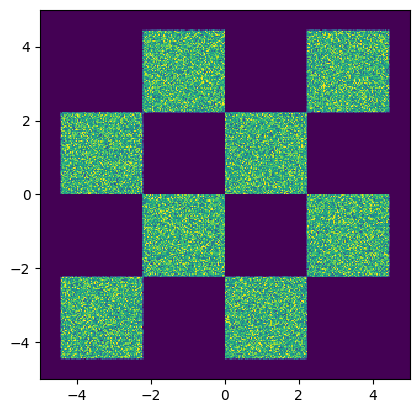

In [8]:
samples = inf_train_gen(jax.random.PRNGKey(0), 500_000)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm)

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

In [9]:
from gensbi.flow_matching.path.scheduler import CondOTScheduler
from gensbi.flow_matching.path import AffineProbPath
from gensbi.flow_matching.solver import ODESolver
from gensbi.utils.model_wrapping import ModelWrapper
from gensbi.flow_matching.loss import ContinuousFMLoss

/lhome/ific/a/aamerio/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array, args=None):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
            t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
            
        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [11]:
hidden_dim = 512

# velocity field model init
vf_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

In [12]:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
# max LR
MAX_LR = 1e-3  # @param{type:"number"}
# Min scale for the learning rate:
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR  # @param{type:"number"}

In [13]:
# reduce on plateau schedule
nsteps = 10_000
nepochs = 10

multistep = 1 # if the GPU cannot support batch sizes of at least 4k, adjust this value accordingly to get the desired effective batch size

# warmup_schedule = optax.schedules.warmup_constant_schedule(1e-5, MAX_LR, warmup_steps=1000)

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    # optax.adamw(warmup_schedule),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(vf_model, opt)

In [14]:
# restore the model
if restore_model:
    checkpointer = ocp.StandardCheckpointer()
    abs_model = nnx.eval_shape(lambda: MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0)))
    abs_state = nnx.state(abs_model)
    # Orbax API expects a tree of abstract `jax.ShapeDtypeStruct`
    # that contains both sharding and the shape/dtype of the arrays.
    abs_state = jax.tree.map(
    lambda a, s: jax.ShapeDtypeStruct(a.shape, a.dtype, sharding=s),
    abs_state, nnx.get_named_sharding(abs_state, mesh)
    )
    loaded_sharded = checkpointer.restore(checkpoint_dir + '/v1',
                                        target=abs_state)

    graphdef, abstract_state = nnx.split(abs_model)
    vf_model= nnx.merge(graphdef, loaded_sharded )
    checkpointer.close()

In [15]:
batch_size = 1024

In [16]:
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

loss_fn = ContinuousFMLoss(path)

@nnx.jit
def train_step(vf_model, optimizer, batch):
    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(vf_model, batch)
    optimizer.update(grads, value=loss)  # In-place updates.

    return loss

In [17]:
val_data = inf_train_gen(jax.random.PRNGKey(1), 512)

In [18]:
@nnx.jit
def val_loss(model, key):
    subkey2, subkey3 = jax.random.split(key, 2)
    x_1 = val_data
    x_0 = jax.random.normal(subkey2, x_1.shape)
    t = jax.random.uniform(subkey3, x_1.shape[0])

    batch = (x_0, x_1, t)
    return loss_fn(model, batch)

In [19]:
from tqdm import tqdm
early_stopping = True

In [20]:
best_state = nnx.state(vf_model)
best_val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

rngs = nnx.Rngs(42)

In [21]:
if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(vf_model)

                vf_model = nnx.merge(graphdef, best_state)
                break

            x_1 = inf_train_gen(rngs.train_step(), batch_size=batch_size) # sample data
            x_0 = jax.random.normal(rngs.train_step(), x_1.shape)
            t = jax.random.uniform(rngs.train_step(), x_1.shape[0])

            batch = (x_0, x_1, t)
            loss = train_step(vf_model, optimizer, batch)  # update model parameters
            l += loss.item()
            
            v_loss = val_loss(vf_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % 100 == 0:
                loss_ = l / 100
                val_ = v_l / 100

                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # if ratio1 < val_error_ratio and ratio2 < 1.05:
                if ratio1 < val_error_ratio:
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(vf_model)
                    elif ratio2 < 1.05:
                        best_state = nnx.state(vf_model) # still update the best state if the ratio is below 1.05

                    counter = 0
                else:
                    counter += 1

                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

    vf_model.eval()



In [22]:
# save the model
if train_model:
    checkpointer = ocp.StandardCheckpointer()
    model_state = nnx.state(vf_model)
    checkpointer.save(checkpoint_dir + '/v1.1', model_state)
    checkpointer.close()

# sample the model

In [23]:
vf_model.eval()

In [24]:
vf_wrapped = ModelWrapper(vf_model)

In [25]:
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 500_000  # batch size
T = jnp.linspace(0,1,10)  # sample times

# x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

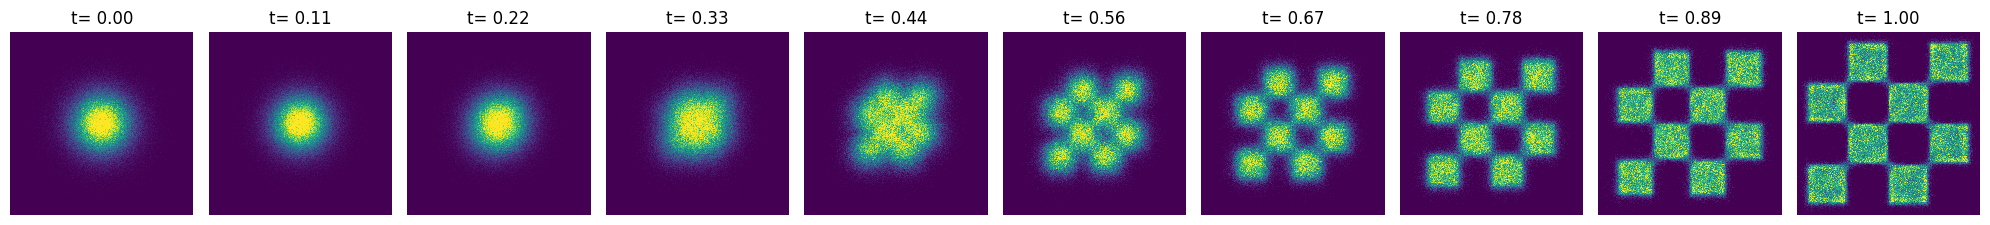

In [26]:
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

In [27]:
sol.shape

(10, 500000, 2)

In [28]:
from gensbi.utils.plotting import plot_marginals

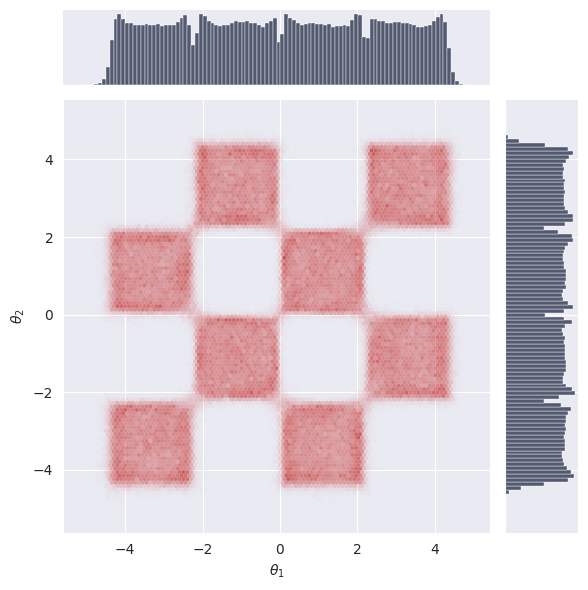

In [36]:
plot_marginals(sol[-1], plot_levels=False, gridsize=100)
plt.show()

In [31]:
batch_size = 1000
T = jnp.linspace(0,1,50)  # sample times

# x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

In [32]:
from gensbi.utils.plotting import plot_trajectories

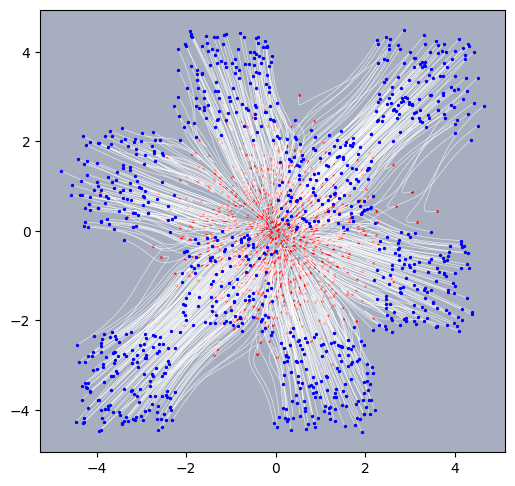

In [33]:
fig, ax = plot_trajectories(sol)
# plt.savefig("flow_matching_2d_unconditional.png", dpi=300, bbox_inches='tight')
plt.show()

# sample the likelihood

In [39]:
import numpyro.distributions as dist

In [40]:
# sample with likelihood

T = jnp.array([1., 0.])  # sample times
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-5, 5, grid_size), jnp.linspace(-5, 5, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [42]:
# source distribution is an isotropic gaussian
gaussian_log_density = dist.Independent(dist.Normal(jnp.zeros(2), jnp.ones(2)), 1).log_prob

In [43]:
sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0], method='Dopri5', step_size=step_size, log_p0=gaussian_log_density)

exact_log_p = sampler(x_1)

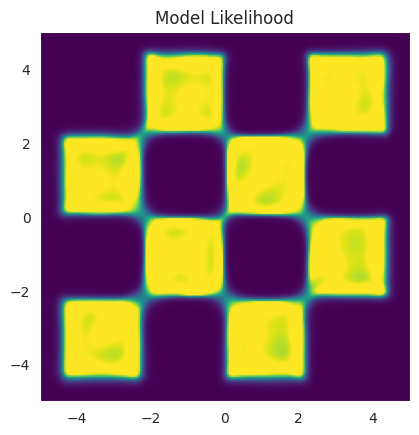

In [46]:
likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

cmin = 0 
cmax = 1/40.5 # the domain goes from -4.5 to 4.5. The total area is (4.5*2)**2. Since only half of the area is covered by the data likelihood, we divide by 2 -> (4.5*2)**2 / 2 = 40.5. As Such 1/40.5 is the max theoretical likelihood value
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

# Create the figure and axis objects explicitly
fig, ax = plt.subplots()

likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
ax.set_title('Model Likelihood')

plt.grid(False)
plt.show()